In [1]:
import numpy as np
import torch
import math

import nibabel as nib
from nibabel.testing import data_path
from nilearn import plotting
import matplotlib.pyplot as plt
from glob import glob

/home/sanketh/.local/lib/python3.5/site-packages/nilearn/__init__.py:68: FutureWarning: Python 3.5 support is deprecated and will be removed in a future release. Consider switching to Python 3.6 or 3.7
  _python_deprecation_warnings()


In [2]:
# size of patches required
block_size = (32,32,32)

# Path to the folder that contains folders of segmentation data
PATH = "../Data/Unprocessed training dataset/TrainingDataset_MSSEG/"
# Takes all folders in the path 
PATH = PATH + "*/"

In [3]:
def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [4]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    data = np.array(data, dtype=np.int16)
    return data

In [14]:
# May not plot as this is not a dedicated cell for plotting 
def plot_input_nifti(input_nifti):
    plotting.view_img(input_nifti)

In [15]:
def get_train_blocks(input_nifti_path):
    '''
    Func to get training blocks of block_size
    
    Cannot be used for validation
    '''
    
    # Load Nifti
    input_nifti = nib.load(input_nifti_path)
    # plot input nifti
    plot_input_nifti(input_nifti)
    # Get affine transform of current input data (Required for plotting Reconstructed 3d image from blocks)
    current_input_affine = input_nifti.affine
    # Get data in numpy format
    data = input_nifti.get_data()
    # Pad zero accordingly to make it multiple of block size
    zero_padded_data = zero_padding(data, block_size)
    
    # Generate dat blocks of block_size
    blocks, unfold_shape = get_data_blocks(data = zero_padded_data, block_size = block_size)
    
    return blocks, unfold_shape, current_input_affine

In [10]:
directory_paths = glob(PATH)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + '3DFLAIR.nii.gz'
    seg1_path = path + 'ManualSegmentation_1.nii.gz'
    seg2_path = path + 'ManualSegmentation_2.nii.gz'
    seg3_path = path + 'ManualSegmentation_3.nii.gz'
    seg4_path = path + 'ManualSegmentation_4.nii.gz'
    seg5_path = path + 'ManualSegmentation_5.nii.gz'
    seg6_path = path + 'ManualSegmentation_6.nii.gz'
    seg7_path = path + 'ManualSegmentation_7.nii.gz'
    
    #Get train block of argument
    blocks, unfold_shape, current_input_affine = get_train_blocks(flair_path)
    #Reconstruct original full scale 3d data from blocks and the unfold shape
    recon = reconstruct(blocks, unfold_shape)

/home/sanketh/.local/lib/python3.5/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/home/sanketh/.local/lib/python3.5/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obt

/home/sanketh/.local/lib/python3.5/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



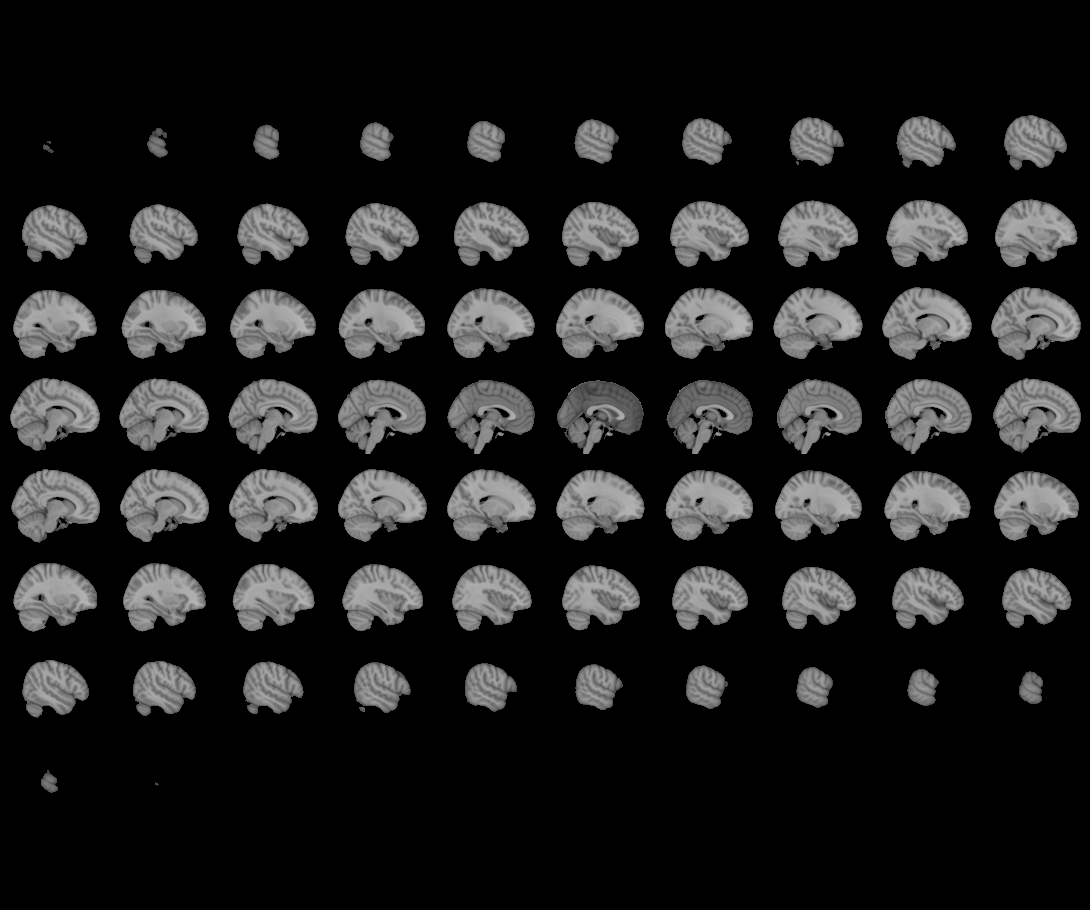
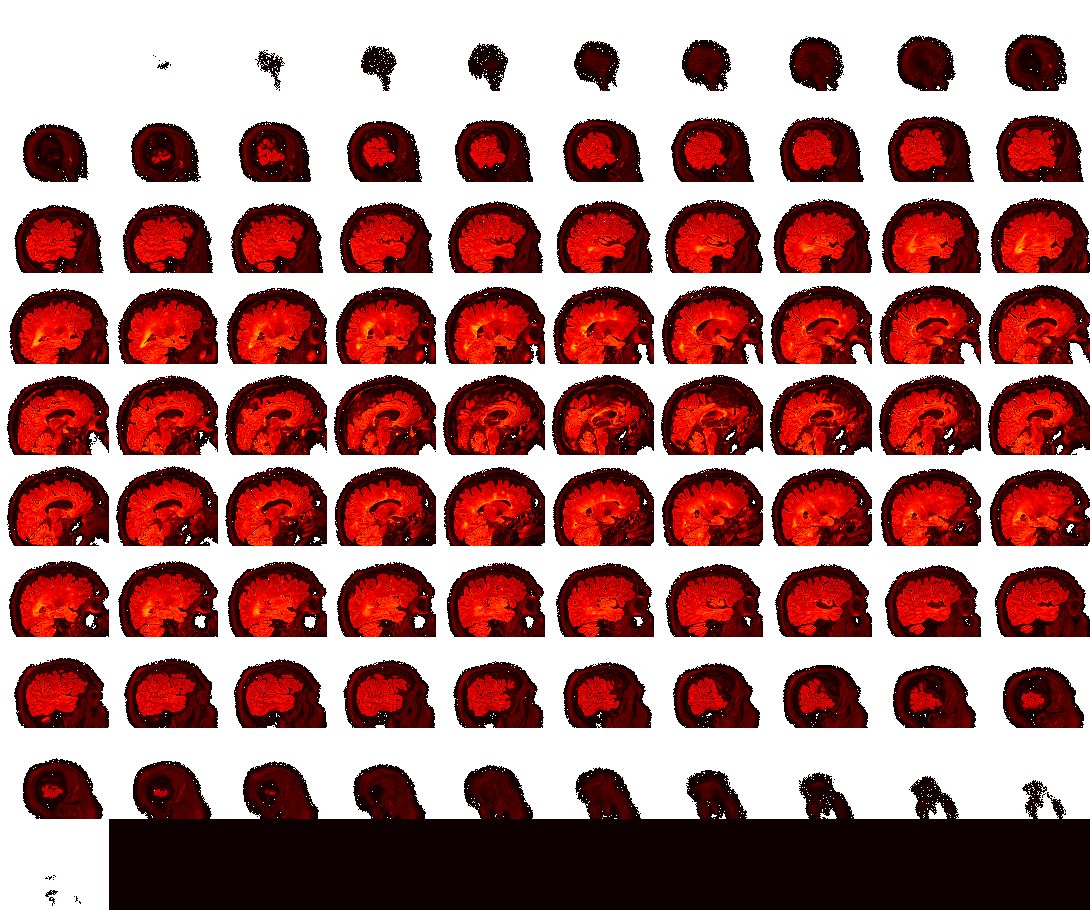

In [11]:
new_image = nib.Nifti1Image(recon, affine=current_input_affine)
plotting.view_img(new_image)